In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
clear_output()

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
import seaborn as sns
import warnings
import os
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from lazypredict.Supervised import LazyClassifier

In [4]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)  

In [5]:
df_raw=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train=df_raw.copy()
sub=pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
test=pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


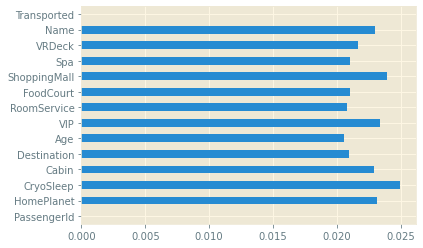

In [7]:
train.isna().mean().plot(kind="barh")
plt.show()

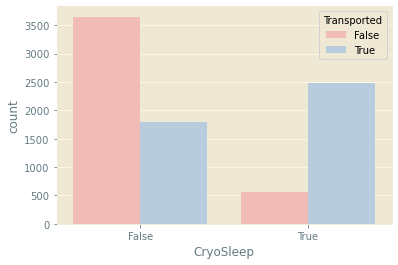

In [8]:
sns.countplot(data=df_raw,x='CryoSleep',hue='Transported', palette='Pastel1')
plt.show()

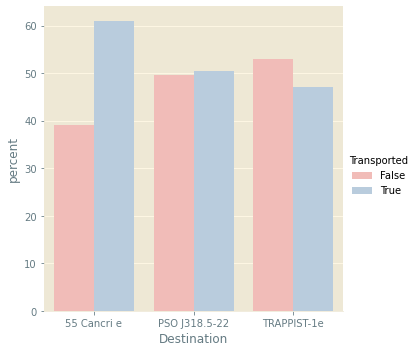

In [9]:
x,y = 'Destination', 'Transported'
(train.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', palette='Pastel1'))
plt.show()

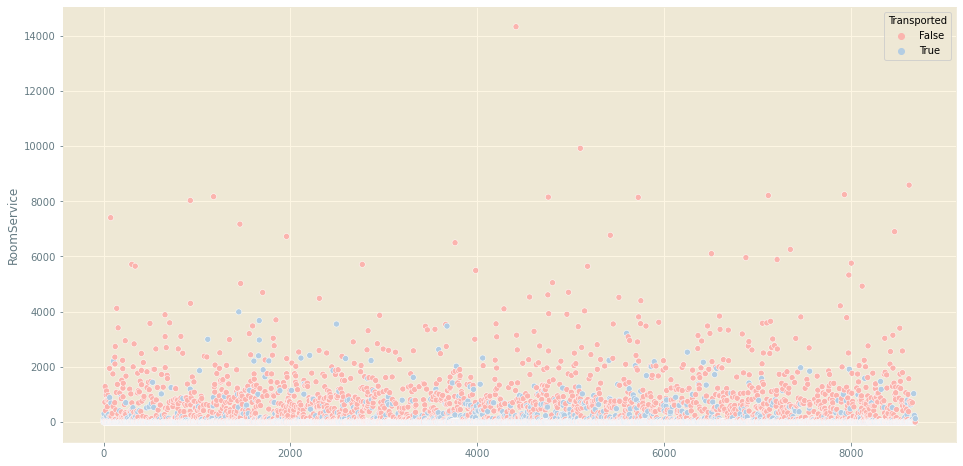

In [10]:
plt.figure(figsize=(16,8))
sns.scatterplot(data=df_raw,x=df_raw.index,y='RoomService',hue='Transported',alpha=1, palette='Pastel1')
plt.show()

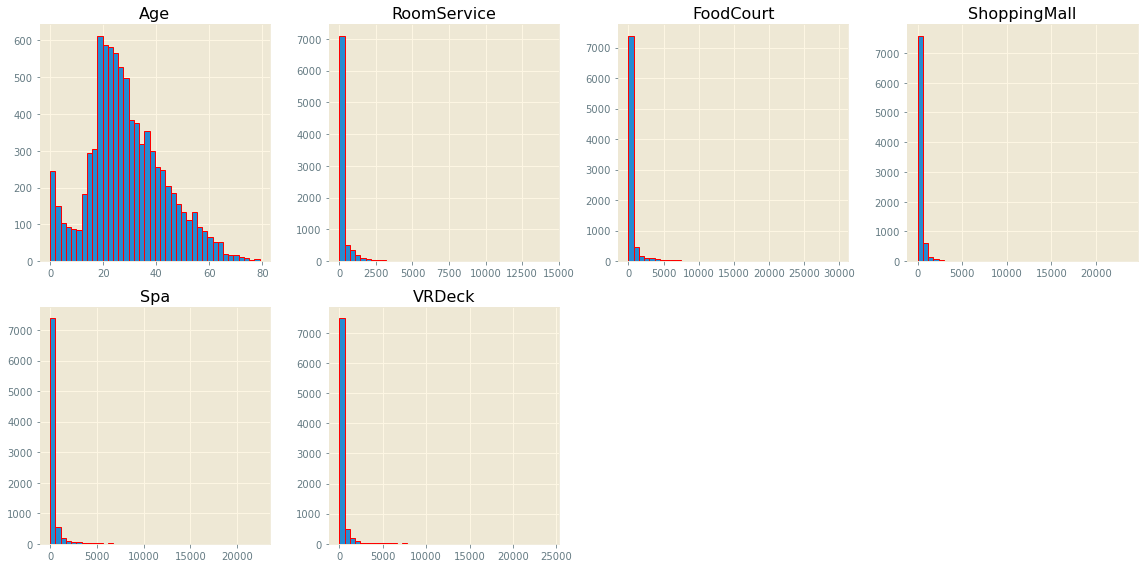

In [11]:
layout_val=(-1, 4)
train.hist(bins=40, figsize=(16,8), layout=layout_val, edgecolor="r")
plt.tight_layout()

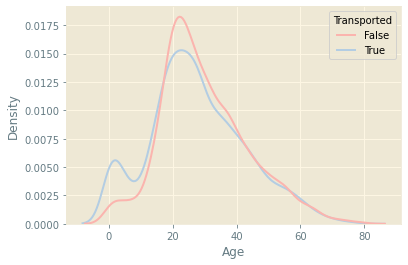

In [12]:
sns.kdeplot(train['Age'],hue=train['Transported'], palette='Pastel1')
plt.show()

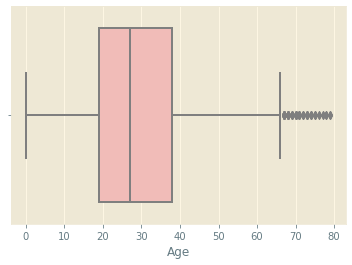

In [13]:
sns.boxplot(train['Age'], palette='Pastel1')
plt.show()

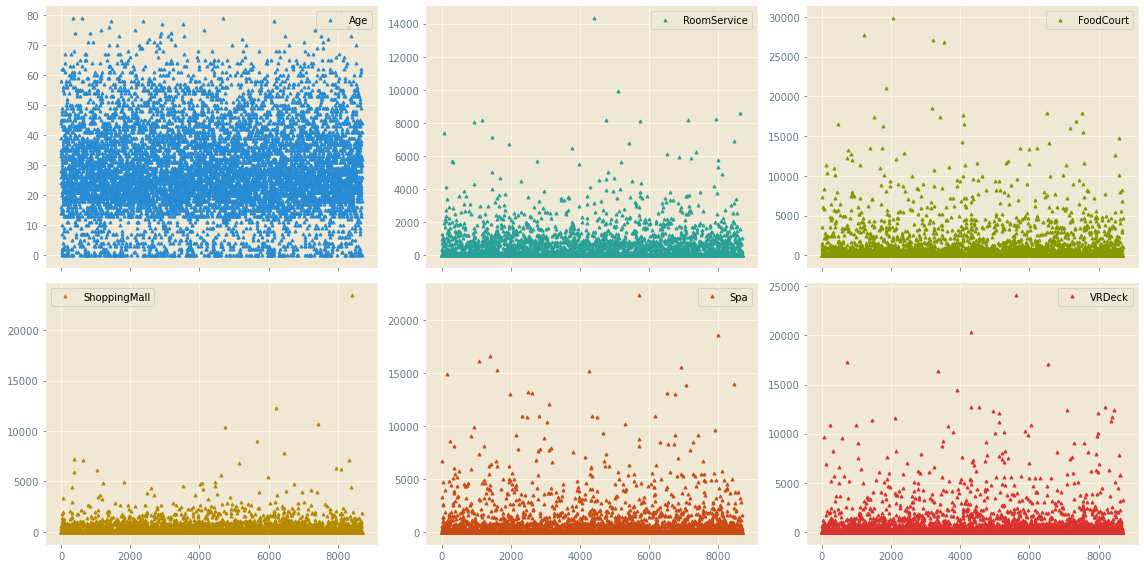

In [14]:
train.plot(lw=0, marker="^", subplots=True, layout=(-1, 3),figsize=(16,8), markersize=3)
plt.tight_layout()

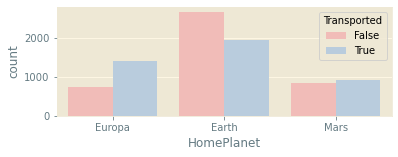

In [15]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['HomePlanet'],hue=train['Transported'],palette='Pastel1')
plt.show()

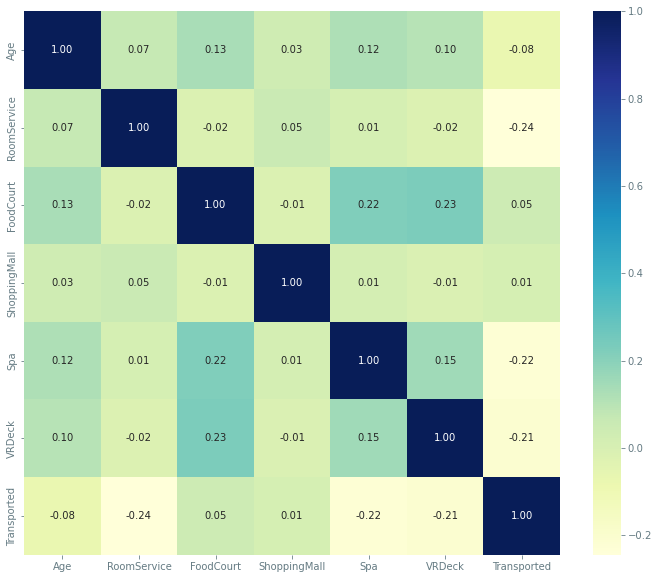

In [16]:
plt.figure(figsize=(12,10))
sns.heatmap(df_raw.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f')
plt.show()

In [17]:
def ImputeNull(df):
    mode_HomePlanet = df['HomePlanet'].mode()[0]
    df['HomePlanet'].fillna(mode_HomePlanet)
    mode_CryoSleep = df['CryoSleep'].mode()[0]
    df['CryoSleep'].fillna(mode_CryoSleep)
    mode_Destination = df['Destination'].mode()[0]
    df['Destination'].fillna(mode_Destination)
    median_Age = df['Age'].median()
    df['Age'].fillna(median_Age)
    mode_VIP = df['VIP'].mode()
    df['VIP'].fillna(mode_VIP) 
    median_RoomService = df['RoomService'].median()
    df['RoomService'].fillna(median_RoomService)
    median_FoodCourt = df['FoodCourt'].median()
    df['FoodCourt'].fillna(median_FoodCourt)
    median_ShoppingMall = df['ShoppingMall'].median()
    df['ShoppingMall'].fillna(median_ShoppingMall)
    median_Spa = df['Spa'].median()
    df['Spa'].fillna(median_Spa)
    median_VRDeck = df['VRDeck'].median()
    df['VRDeck'].fillna(median_VRDeck)
    mode_Cabin_Deck = df['Cabin_Deck'].mode()
    df['Cabin_Deck'].fillna(mode_Cabin_Deck) 
    mode_Cabin_Side = df['Cabin_Side'].mode()
    df['Cabin_Side'].fillna(mode_Cabin_Side) 
    return df

In [18]:
def label_encoder(df):
    columns = ["HomePlanet", "CryoSleep","Cabin_Deck","Cabin_Side", "Destination" ,"VIP"]
    for col in columns:
        df[col] = df[col].astype(str)
        df[col] =  LabelEncoder().fit_transform(df[col])
    return df

In [19]:
def preProcess(df):
    df=df.assign(PassengerId_GroupId=df['PassengerId'].str[:4].astype(np.int16),PassengerId_PassengerNumber=df['PassengerId'].str[5:].astype(np.int16))
    df=df.assign( Cabin_Deck=df["Cabin"].str.split("/").str[0],Cabin_Num=df["Cabin"].str.split("/").str[1],Cabin_Side=df["Cabin"].str.split("/").str[2])
    df=df.drop(columns=['PassengerId','Cabin','PassengerId_PassengerNumber','Cabin_Num','Name'])
    df=ImputeNull(df)
    df=label_encoder(df)
    return df

In [20]:
X = df_raw.drop('Transported' , axis =1 )
Y = df_raw['Transported']
X_train , X_test , Y_train , Y_test = train_test_split(X , Y, random_state = 5 ,test_size =0.40)

In [21]:
X_train=preProcess(X_train)
X_test=preProcess(X_test)

In [22]:
clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None,predictions=False,random_state=12,classifiers='all')
models, predictions = clf.fit(X_train , X_test , Y_train , Y_test)

100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


In [23]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier( random_state=5)
lgbm.fit(X_train, Y_train)
y_pred = lgbm.predict(X_test)

In [24]:
test=preProcess(test)
y_pred = lgbm.predict(test)

In [25]:
sub['Transported'] = y_pred.astype("bool")
sub.to_csv("spaceshiptitanic.csv",index=False)
sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
